## Import Packages

In [7]:
import time
import pandas as pd
import numpy as np
import datetime as dt
from math import *
import logging


# And some Machine Learning modules from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from copy import copy
from sklearn import preprocessing
from sklearn.metrics import cohen_kappa_score
from category_encoders import *
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn import ensemble
from sklearn import metrics

from sklearn.pipeline import Pipeline

# Some modules for plotting and visualizing
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


# In[232]:


from collections import Counter
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.datasets import make_classification
import category_encoders
import functools
import imblearn
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced


## Load data files

In [8]:
col=['flex', 'pays', 'fab', 'vds', 'chass', 'checkD', 'year', 'plant']
clus_var = pd.read_csv('chassis/cluster_de_variante.csv') #Données sur les variantes
df_mixed = pd.read_csv('chassis/df_mixed.csv') #Données mixtes composées de VIN français, suédois et espagnols

/home/eyram/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Filtering

In [9]:
# Filtrage des variantes n'ayant pas plus de 20 VIN
min_instances = 20
b = pd.DataFrame.from_dict(Counter(df_mixed['idvariante']), orient='index').sort_values(by=0)
df_mixed = df_mixed[ df_mixed['idvariante'].isin( list(b[ b[0] > min_instances ].index ) ) ]

## Useful Functions

In [11]:
#Function to loop classification 

# Cluster = désigne le cluster dont on calcule le modèle
# df = Dataset utilisé pour la classification
# y_col = Colonne de la cible à prédir (Peut etre les variantes ou les clusters de variantes)
# resample = Booléen désignant si on doit équilibrer la distribution des classes ou non (Il s'agit de generer des elements factices pour eviter un biais dans le calcul)
# cv = Booléen désignant si on doit rechercher les meilleurs hyperparametres ou non
# col = Colonne des features à utiliser dans le calcul du modele
# name = Nom donné au modele généré
# filtering = Booléen désignant si on doit filtrer ou non le dataset d'entrée

# L'utilisation du cv peut etre très couteux en temps, c'est pourquoi par défaut il est False.
#
# L'utilisation de resample peut egalement etre couteux en temps de calcul néanmoins il est True par défaut car affecte 
# beaucoup le taux de prédiction finale

def CalculClassification(cluster='clus', df=df_mixed, y_col='class', resample = True, cv= False, col=col, name = None, filtering=True  ):
    
    from sklearn.externals import joblib
    
    # Définition du logFile
    logging.basicConfig(filename='calcul_chassis-{}.log'.format(str(dt.datetime.now().date())) ,level=logging.DEBUG)
    logging.basicConfig(format='%(asctime)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

    # Les 3 paramètres ci-dessus étaient en paramètres de la fonction mais on été fixé pour éviter un calcul trop long
    # Néanmoins leur but est de rechercher pour chaque modele calculé, l'algorithme adéquat (entre Random Forest, Gradient Boosting, Bagging)
    #
    # one = désigne la variable permettant d'initialiser ou non la recherche du meilleur algo, si il est False, on lance la recherche
    # sinon il ne considere qu'un algo au choix
    #
    #loop = permet de faire une boucle pour relancer un hyperparamétrage sur le meilleur algo trouvé
    #clf = variable qui contiendra plus tard le meilleur modele 
    loop = 0
    one = True
    clf = None


    #Filtering
    if cluster == 'clus':
        DF = df.drop(columns ='idvariante')
        y_col = 'class'
        
    elif type(cluster) == int or type(cluster) == np.int64 :
        if y_col == 'class':
            if filtering:
                DF = df[ df['class'] == cluster ].drop(columns = 'idvariante')
            else:
                DF = df.drop(columns = 'idvariante')
        elif y_col == 'idvariante':
            if filtering :
                DF = df[ df['class'] == cluster ].drop(columns='class')
            else :
                DF = df.drop(columns = 'class')
    else:
        raise ValueError('A very specific bad thing happened')
        
    if not name:
        name = cluster

    #Encodage
    logging.info('{}/{}'.format(name,'encodage') )
    x_cols = DF.columns.drop(y_col)
    
    
    y = DF[y_col]
    X = DF[x_cols]

    
    display(DF.shape)
    display(Counter(y))
    
    
    ce_x = BinaryEncoder(cols=col).fit(X,y)
    X_num = ce_x.transform(X)
    joblib.dump(ce_x, 'chassi__s/encoder/enc_clus%s' % name )


    #Label Encoding    
    logging.info('{}/{}'.format(name,'label_encoding') )
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y_res = le.transform(y)
    joblib.dump(le, 'chassi__s/label/label_clus%s' % name)

    
    #Resampling
    logging.info('{}/{}'.format(name,'resampling') )
    if resample:
        #rus = imblearn.under_sampling.RandomUnderSampler(random_state=42)
        rus = imblearn.over_sampling.SMOTE(n_jobs=-1, kind='borderline1')
        X_res, Y_res = rus.fit_sample(X_num, y_res)
    else:
        X_res, Y_res = X_num, y_res


    # Affichage distribution par classes
    %matplotlib inline
    nb_counts = Counter(Y_res)
    tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)

    index = tdf.index.tolist()

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.bar(range(len(index)), tdf[0].tolist())
    ax.axhline(500) 

    plt.xlabel('Classe', fontsize=15)
    plt.ylabel('Nb instances', fontsize=15)
    plt.xticks(range(len(index)), index, fontsize=10, rotation=30)
    plt.show()

    # Split train and test
    X_train, X_test, y_train, y_test = train_test_split( X_res, Y_res, test_size=0.2, random_state=20,  stratify=Y_res)

    # Training and evaluation
    logging.info('{}/{}'.format(name,'training') )
    
    #while loop < 2: #Décommenter cette ligne implique la correction de l'indentation
    
    if one == True:
        #clf = ensemble.GradientBoostingClassifier(n_estimators=100)
        clf = ensemble.RandomForestClassifier(n_estimators=100, 
                                            criterion='entropy',
                                            min_samples_split=3, 
                                            random_state = 42, 
                                            max_depth=25, 
                                            n_jobs=-1,  
                                            class_weight=None)
        
        if cluster == 'clus':
            clf = ensemble.BaggingClassifier(n_estimators=100)

        if cv:
            if 'max_depth' in clf.get_params():
                grid = [{
                    #'n_estimators': [ 100, 150],
                    'max_depth': [ None,  15, 20 ],
                    #'criterion': ['entropy', 'gini']
                }]
            elif 'max_samples' in clf.get_params():
                grid = [{
                    'n_estimators': [100, 200], 
                    'max_features': [ 1.0]
                }]
            cv = GridSearchCV(clf, grid, scoring='accuracy', cv=None)
            cv.fit(X_train, y_train)
            logging.info('{}/{}'.format(cluster,metrics.accuracy_score(y_test, cv.predict(X_test))) )
            clf = cv
        else:
            clf.fit(X_train, y_train)
            logging.info('{}/{}'.format(cluster, metrics.accuracy_score(y_test, clf.predict(X_test))) )

        # Display Evaluation result
        print(metrics.classification_report( y_test, clf.predict(X_test) ))

        #Saving model
        from sklearn.externals import joblib
        joblib.dump(clf, 'chassi__s/model/cls_%s' % name)

    else:
        # Recherche du meilleur algo 
        pipeline = Pipeline([('est', ensemble.RandomForestClassifier())])

        grid = [
            {'est': [ensemble.BaggingClassifier()] },
            {'est': [ensemble.RandomForestClassifier()] },
            {'est': [ensemble.GradientBoostingClassifier()] },
            {'est': [ensemble.AdaBoostClassifier()] },
        ]

        grid_test = [{
            'est': [\
                    ensemble.BaggingClassifier(), \
                    ensemble.RandomForestClassifier(), \
                    ensemble.GradientBoostingClassifier(), \
                    ensemble.AdaBoostClassifier()\
                   ]
        }]

        gs = GridSearchCV(pipeline, grid, scoring='accuracy', n_jobs=-1)

        gs.fit(X_train, y_train)

        errvals = np.array([])

        this_err = metrics.accuracy_score(y_test, gs.predict(X_test))

        print(this_err)
        logging.info('{}/{}'.format(cluster,this_err) )
        
        clf = gs.best_estimator_.steps[0][1]
        one = True

    loop+=1

## Run Classification

Ici on determine les clusters qui ont plus de 100 variantes, pour ces cas un autre algorithme leur sera appliqué

In [12]:
highvar = [] # list des clusters ayant trop de variantes

_count = {}
for name, group in df_mixed.groupby([df_mixed['class'], df_mixed['idvariante']]):
    try:
        _count[ name[0] ] = _count[ name[0] ] + 1
    except KeyError:
        _count[ name[0] ] = 0
for i,k in _count.items():
    if k > 100:
        highvar.append(i)

# 'clus' désigne le valeur pour calculer le modele permettant de prédire les clusters de variantes
# __list_clus contient les clusters ayant un nombre de variantes inférieur à 100
__list_clus = ['clus'] + list(set(df_mixed['class'].unique()) - set(highvar))

In [ ]:
for i in __list_clus:
    if i == 'clus':
        CalculClassification(cluster=i, resample=False)
    else:
        CalculClassification(cluster=i, y_col='idvariante')

(194741, 10)

Counter({42641: 11668,
         42643: 11661,
         70949: 12039,
         70959: 5120,
         71196: 1814,
         71201: 40,
         138649: 351,
         138659: 73,
         138663: 22,
         140647: 183,
         165446: 95,
         165456: 59,
         170273: 255,
         170274: 70,
         174016: 94,
         174049: 38,
         201661: 248,
         201663: 516,
         201665: 232,
         201667: 46,
         201675: 32094,
         201677: 58,
         201680: 11343,
         201681: 1134,
         201683: 496,
         201685: 1624,
         201688: 444,
         201689: 4134,
         201691: 730,
         201692: 255,
         214440: 428,
         214441: 742,
         214442: 2898,
         279908: 895,
         301981: 23,
         305188: 156,
         305189: 225,
         305190: 41,
         305191: 7560,
         305772: 38,
         306041: 1060,
         333006: 98,
         349761: 83,
         349945: 63,
         352405: 203,
         35240

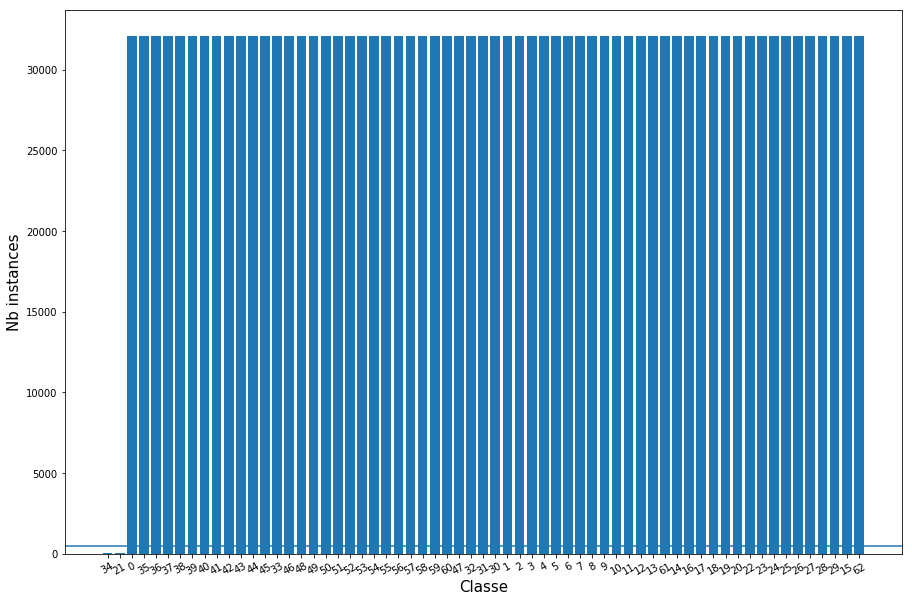

             precision    recall  f1-score   support

          0       0.82      0.77      0.79      6419
          1       0.70      0.61      0.65      6419
          2       0.53      0.47      0.50      6419
          3       0.62      0.51      0.56      6419
          4       0.73      0.74      0.74      6418
          5       0.94      0.96      0.95      6418
          6       0.79      0.85      0.82      6419
          7       0.90      0.93      0.91      6419
          8       0.76      0.86      0.81      6419
          9       0.73      0.72      0.73      6419
         10       0.75      0.82      0.79      6419
         11       0.78      0.83      0.81      6419
         12       0.79      0.78      0.78      6418
         13       0.90      0.98      0.94      6419
         14       0.95      0.95      0.95      6419
         15       0.97      0.97      0.97      6419
         16       0.96      0.97      0.97      6419
         17       0.94      0.92      0.93   

In [21]:
CalculClassification(cluster=34, y_col='idvariante')

**La fonction ci-dessous automatise le calcul des modeles pour les clusters plus de 100 variantes.
En effet, au delà de 100 variantes, le modèle calculé devient très volumineux et moins précis.**

**Pour ce faire on détermine d'autres clusters de variantes intermédiaires pour réduire le nombre de variantes le clusters.**

*Ex: Cluster A = 120 Variantes => Cluster A-1 = 70 variantes et Cluster A-2 = 50 variantes*

**On calcule ainsi un modele pour prédire ces nouveaux clusters et un autre modele pour prédire les variantes à l'intérieur de ces clusters.**

**Pour determiner les clusters, on se base sur des attributs issues de la table des variantes, ces attributs sont choisis
par rapport à leur aptitude à scinder de facon plus ou moins uniforme les variantes à l'interieur du cluster et aussi de garder une certaine cohérence métier.**

*Ex: modele => regroupe les variantes dans des clusters ayant des modeles distincts*

In [ ]:
# Attribut pour determiner les clusters intermédiaires
__att = {}
__att[7] = ['modele','vitessesnbr']
__att[9] = ['modele','energie']
__att[17] = ['carosserie']
__att[11] = ['energie']
__att[29] = ['modele', 'carosserie']

#Fonction récursive qui calcule tous les modeles des clusters à variantes élevé ( cluster intermédiaire -> variante )
def ClassiMultiNiveau(DF, attr_list, cluster, clus_var_loc, name=None ):
    col = attr_list.pop(0)
    
    attr =  clus_var_loc[col].unique().tolist()

    
    for j,x in enumerate(attr):
        variante_list = clus_var_loc[ clus_var_loc[col] == x ]['id'].tolist()
        DF.loc[ DF['idvariante'].isin(variante_list), 'class' ] = j
    
    if not name:
        rad = str(cluster)
    else:
        rad = name
              
    CalculClassification(cluster=i, df=DF, y_col='class', filtering=False, name=rad)
    
    for j in Counter(DF['class']):
        display('%s------%s' % (rad,j))
        DF_x = DF[ DF['class'] == j ]

        if len( DF_x['idvariante'].unique()) > 90:
            name = rad + '_%s'%j
            
            clus_var_loc = clus_var_loc[ clus_var_loc[col] == attr[j] ]
            ClassiMultiNiveau( DF=DF_x, attr_list=attr_list, cluster= i, clus_var_loc=clus_var_loc, name=name)
        else:
            name = rad + '_%s'%j
            CalculClassification(cluster=i, df=DF_x, y_col='idvariante', filtering=False, name=name)
            




for i,k in __att.items():
    
    DF = df_mixed[ df_mixed['class'] == int(i) ]
    ClassiMultiNiveau(DF=DF, attr_list=k, cluster=i, clus_var_loc = clus_var[ clus_var['cluster'] == i ])
